In [97]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

from sklearn.metrics import mean_squared_error,mean_absolute_error

import warnings
warnings.filterwarnings('ignore')
import pprint

2.0.0


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)
np.random.seed(1234)

### Load Data

In [3]:
sequence_data=pd.read_csv('sequence_data.csv', parse_dates=['Date'], index_col='Date')
sequence_data=sequence_data.head(794)

In [4]:
sequence_data['Volume']=sequence_data['Volume'].astype('float32')
# sequence_data.index=sequence_data['Date']
sequence_data.index.freq='D'

In [5]:
sequence_data.index

DatetimeIndex(['2008-01-01', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-05', '2008-01-06', '2008-01-07', '2008-01-08',
               '2008-01-09', '2008-01-10',
               ...
               '2010-02-23', '2010-02-24', '2010-02-25', '2010-02-26',
               '2010-02-27', '2010-02-28', '2010-03-01', '2010-03-02',
               '2010-03-03', '2010-03-04'],
              dtype='datetime64[ns]', name='Date', length=794, freq='D')

In [6]:
sequence_data.dtypes

Volume    float32
dtype: object

In [7]:
sequence_data.tail(10)

,Volume
Date,
2010-02-23,1752.0
2010-02-24,1681.0
2010-02-25,1877.0
2010-02-26,1766.0
2010-02-27,1498.0
2010-02-28,1252.0
2010-03-01,1100.0
2010-03-02,1812.0
2010-03-03,1750.0


In [6]:
sequence_data['Volume'].isnull().sum()

0

### Visualize Time Series

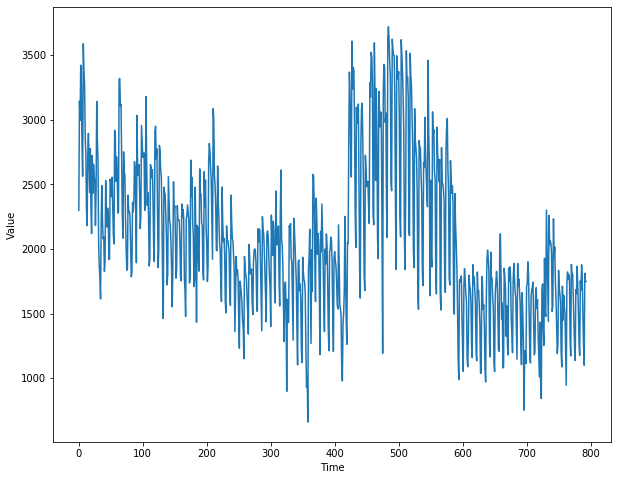

In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10,8))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)
    
    
time = np.arange(0,794, dtype="float32")
series=np.array(sequence_data['Volume'])

split_time = 730 #update from 365 to 730
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 15
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [7]:
print(series.shape, time.shape)

(794,) (794,)


In [8]:
print(x_train.shape, time_train.shape, x_valid.shape, time_valid.shape)

(730,) (730,) (64,) (64,)


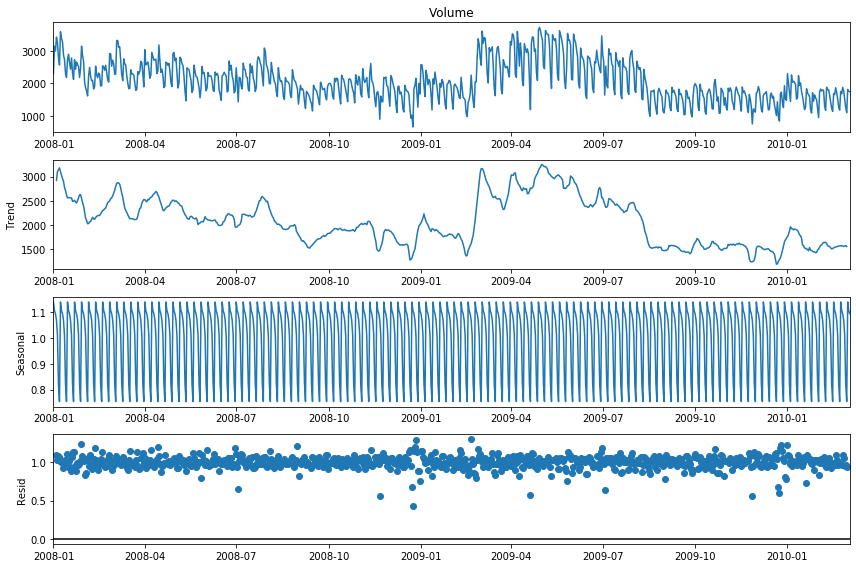

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize']=12,8

result = seasonal_decompose(sequence_data['Volume'], model='multiplicative')  # model='mul' also works
result.plot();

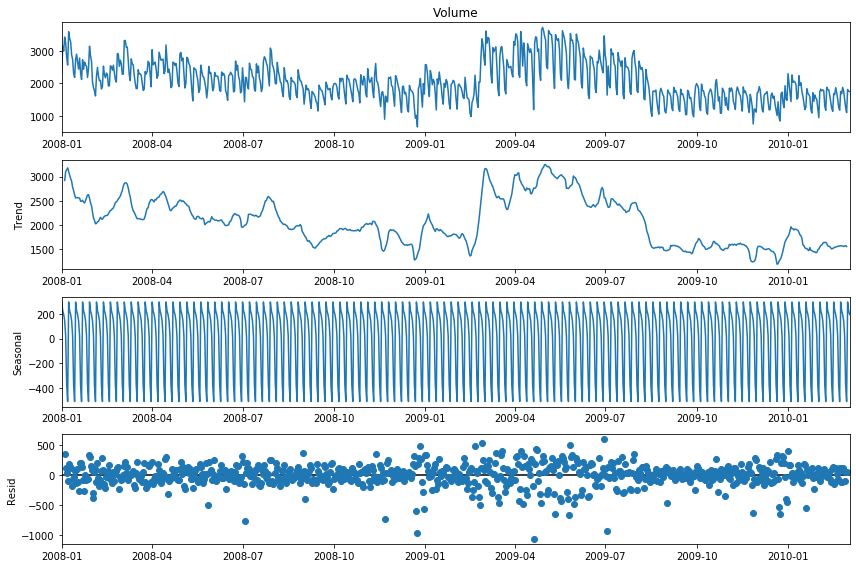

In [10]:
result = seasonal_decompose(sequence_data['Volume'], model='addictive')  # model='mul' also works
result.plot();

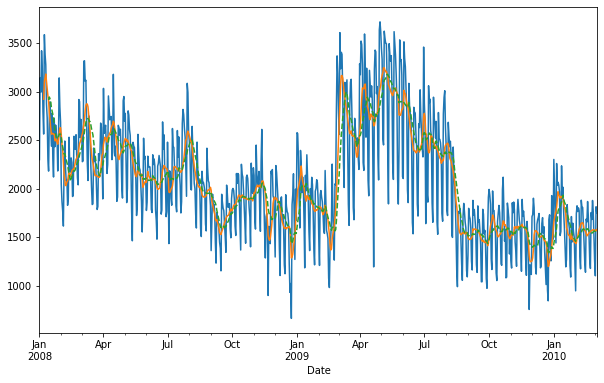

In [11]:
sequence_data['Volume'].plot(figsize=(12,6))
sequence_data['Volume'].rolling(window=7).mean().plot(figsize=(10,6))
sequence_data['Volume'].rolling(window=14).mean().plot(figsize=(10,6),  ls='--');

In [12]:
# create dataframes to be used by statmodels
x_train_df = sequence_data[:split_time]
x_valid_df = sequence_data[split_time:]

# Moving Average

  ### 1) Naive Forecast

use previous day actual to forecast the next day, below is naive forecast with numpy

In [13]:
naive_forecast = series[split_time - 1:-1]

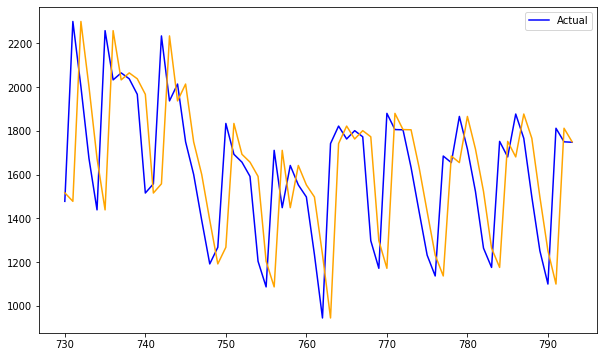

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, color='blue')

plt.legend(['Actual'])
# sequence_data['Volume'][split_time:].plot(legend=True, label='Actual')
ax2=plt.plot(time_valid, naive_forecast, color='orange')
# plt.legend(['Naive Forecast']);

In [15]:
# this is not a true forecast benchmark because the naive forecast using the previous day data to predict tomorrow's data
# this doesn't allow forecast a long period into the future
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

239.92188


In [16]:
review_naive_forecast=pd.DataFrame()

review_naive_forecast['Actual']=(x_valid).astype(int)
review_naive_forecast['NF']=(naive_forecast).astype(int)

review_naive_forecast.tail(10)

,Actual,NF
54,1752,1176
55,1681,1752
56,1877,1681
57,1766,1877
58,1498,1766
59,1252,1498
60,1100,1252
61,1812,1100
62,1750,1812
63,1748,1750


#### pandas.dataframe.shift

In [76]:
x_valid_df['NF']=sequence_data.iloc[split_time-1:-1]['Volume'].shift(1)
x_valid_df[['Volume','NF']].tail(10)

,Volume,NF
Date,,
2010-02-23,1752.0,1176.0
2010-02-24,1681.0,1752.0
2010-02-25,1877.0,1681.0
2010-02-26,1766.0,1877.0
2010-02-27,1498.0,1766.0
2010-02-28,1252.0,1498.0
2010-03-01,1100.0,1252.0
2010-03-02,1812.0,1100.0
2010-03-03,1750.0,1812.0


### 2) Simple Moving Average

numpy approach to generate moving average

In [17]:
# calculates moving average
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [18]:
moving_avg = moving_average_forecast(series, window_size)[split_time - window_size:]

len(moving_avg)

64

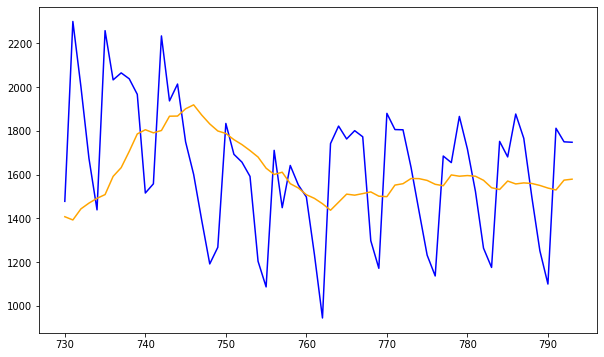

In [19]:
# simple 15 day moving average
moving_avg = moving_average_forecast(series, window_size)[split_time - window_size:]

plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, color='blue')
plt.plot(time_valid, moving_avg, color='orange');

In [20]:
# this is worse than the naive forecast
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

268.30103


pandas dataframe.rolling

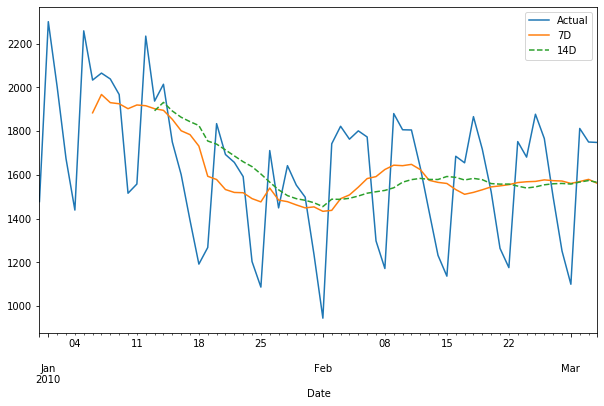

In [21]:
sequence_data['Volume'][split_time:].plot(figsize=(10,6),legend=True, label='Actual')
sequence_data['Volume'][split_time:].rolling(window=7).mean().plot(figsize=(10,6), legend=True, label='7D')
sequence_data['Volume'][split_time:].rolling(window=14).mean().plot(figsize=(10,6),  ls='--', legend=True, label='14D');

### 3) Exponential Weighted Moving Average

ewma has only one smoothing factor alpha and didn't consider trend or seasonality

In [22]:
sequence_data['ewma']=sequence_data['Volume'].ewm(span=7,adjust=False).mean()
sequence_data['simple_avg']= sequence_data['Volume'].rolling(window=7).mean()

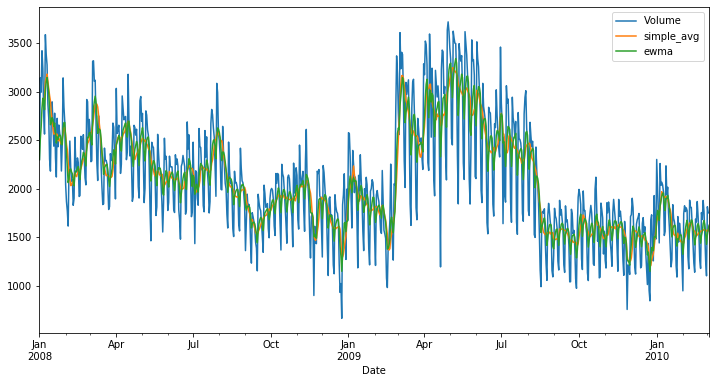

In [23]:
sequence_data[['Volume','simple_avg','ewma']].plot(figsize=(12,6));

In [39]:
# temp_x_valid = sequence_data['Volume'][365:]
# ewma_moving_avg = sequence_data['ewma'][365:]
# print(tf.keras.metrics.mean_absolute_error(temp_x_valid, ewma_moving_avg).numpy())

269.3898630612991


### Holt's Method (Double Exponential Smoothing)

introduce a new smoothing factor (beta) that addresses trend

### Holt-Winters Method (Triple Exponential Smoothing)

introduce a smoothing factor (gamma) that addresses seasonality

In [40]:
# D is calendar day
sequence_data.index.freq='D'

In [24]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [25]:
span = 7
alpha = 2/(span+1)
sequence_data['ewma_7']=sequence_data['Volume'].ewm(alpha=alpha,adjust=False).mean()

In [26]:
sequence_data[['Volume','ewma','ewma_7']].head(10)

,Volume,ewma,ewma_7
Date,,,
2008-01-01,2299.0,2299.000000,2299.000000
2008-01-02,3143.0,2510.000000,2510.000000
2008-01-03,2994.0,2631.000000,2631.000000
2008-01-04,3421.0,2828.500000,2828.500000
2008-01-05,3241.0,2931.625000,2931.625000
2008-01-06,2793.0,2896.968750,2896.968750
2008-01-07,2562.0,2813.226562,2813.226562
2008-01-08,3587.0,3006.669922,3006.669922
2008-01-09,3384.0,3101.002441,3101.002441


In [27]:
# this gives the  same value as ewma
span = 7
alpha = 2/(span+1)
model = SimpleExpSmoothing(x_train_df['Volume'])

fitted_model = model.fit(smoothing_level=alpha, optimized=False)

In [28]:
fitted_model.fittedvalues.shift(-1)[:10]

Date
2008-01-01    2299.000000
2008-01-02    2510.000000
2008-01-03    2631.000000
2008-01-04    2828.500000
2008-01-05    2931.625000
2008-01-06    2896.968750
2008-01-07    2813.226562
2008-01-08    3006.669922
2008-01-09    3101.002441
2008-01-10    3144.751831
Freq: D, dtype: float64

In [80]:
x_train_df.tail(10)

,Volume
Date,
2009-12-21,1010.0
2009-12-22,1434.0
2009-12-23,951.0
2009-12-24,842.0
2009-12-25,1678.0
2009-12-26,1729.0
2009-12-27,1398.0
2009-12-28,1254.0
2009-12-29,1927.0


In [86]:
fitted_model.forecast()

2009-12-31    1504.533539
Freq: D, dtype: float64

In [ ]:
# in one line
simple_ma=np.array(SimpleExpSmoothing(x_train_df['Volume'].fit(smoothing_level=alpha, optimized=False).fittedvalues.shift(-1)))

### Triple EWMA

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [30]:
# DO NOT NEED TO SHIFT!!!

sequence_data['triple_ewma'] = ExponentialSmoothing(sequence_data['Volume'], 
                                                    trend='multiplicative',
                                                    seasonal='mul',
                                                    seasonal_periods=365
                                                   ).fit().fittedvalues

C:\Users\Miaojunli\Anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\Miaojunli\Anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\Miaojunli\Anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [31]:
sequence_data[['Volume','triple_ewma']].tail(90)

,Volume,triple_ewma
Date,,
2009-12-05,1493.0,1532.798476
2009-12-06,1192.0,1348.242480
2009-12-07,1118.0,1118.142369
2009-12-08,1632.0,1185.651455
2009-12-09,1679.0,1700.363330
2009-12-10,1704.0,1716.061669
2009-12-11,1743.0,1626.626456
2009-12-12,1430.0,1542.768377
2009-12-13,1182.0,1359.554190


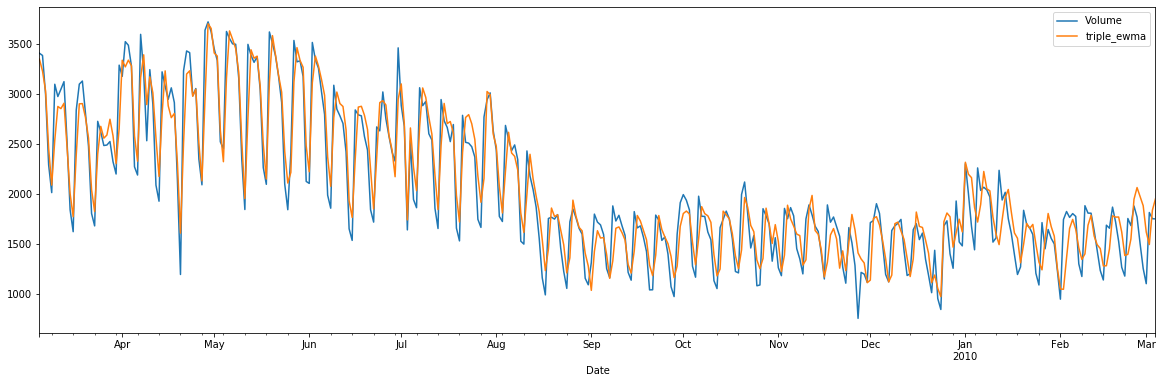

In [32]:
sequence_data[['Volume','triple_ewma']].iloc[-365:].plot(figsize=(20,6));

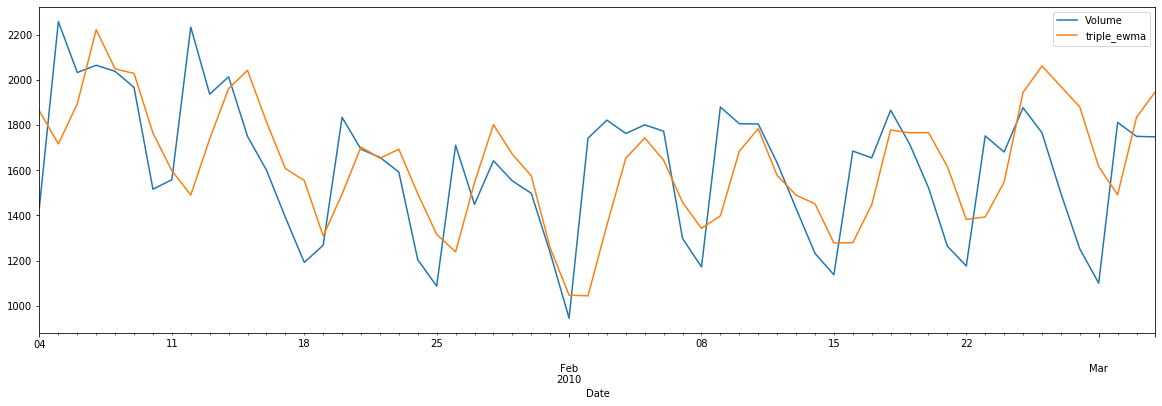

In [33]:
sequence_data[['Volume','triple_ewma']].iloc[-60:].plot(figsize=(20,6));

In [105]:
# sequence_data['double_ewma'][365:]

In [37]:
# temp_x_valid = sequence_data['Volume'][365:]
# # double_ewma_moving_avg = sequence_data['double_ewma'][365:]
# print(tf.keras.metrics.mean_absolute_error(temp_x_valid, triple_ewma).numpy())

### Using Triple EWMA to Forecast

In [90]:
x_train_df.head(5)

,Volume
Date,
2008-01-01,2299.0
2008-01-02,3143.0
2008-01-03,2994.0
2008-01-04,3421.0
2008-01-05,3241.0


In [38]:
fitted_model = ExponentialSmoothing(x_train_df['Volume'], 
                                    trend='multiplicative',
                                    seasonal='mul',
                                    seasonal_periods=365
                                    ).fit()

C:\Users\Miaojunli\Anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [39]:
test_predictions = fitted_model.forecast(64)

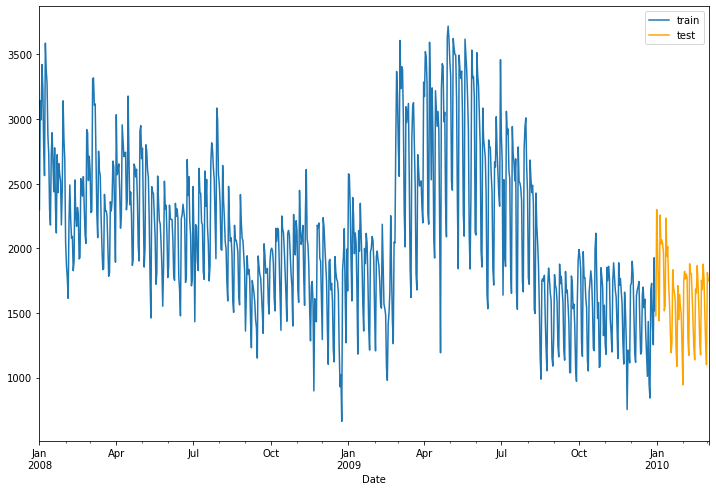

In [40]:
x_train_df['Volume'].plot(legend=True, label='train', figsize=(12,8))
x_valid_df['Volume'].plot(legend=True, label='test',color='orange');

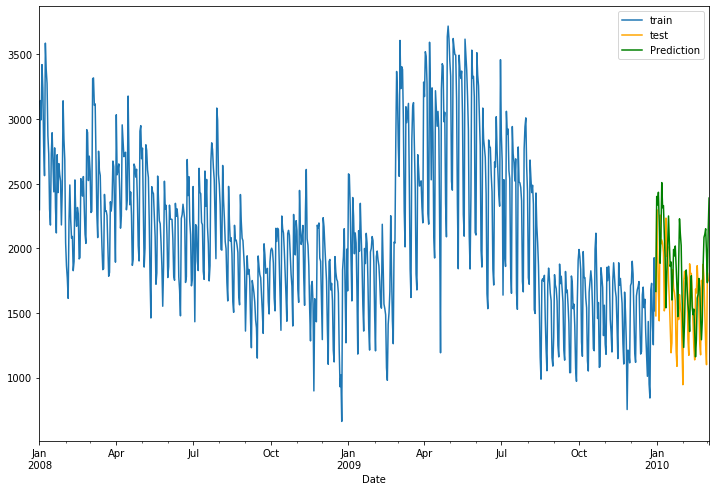

In [41]:
x_train_df['Volume'].plot(legend=True, label='train', figsize=(12,8))
x_valid_df['Volume'].plot(legend=True, label='test',color='orange')
test_predictions.plot(legend=True, label='Prediction', color='green');

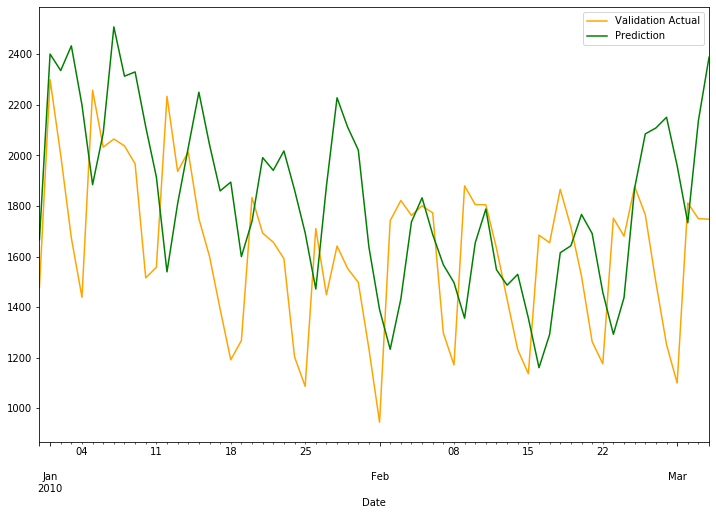

In [42]:
x_valid_df['Volume'].plot(legend=True, label='Validation Actual',color='orange', figsize=(12,8))
test_predictions.plot(legend=True, label='Prediction', color='green');

In [43]:
# seem to overforecast
print(tf.keras.metrics.mean_absolute_error(x_valid, np.array(test_predictions)).numpy())

361.0508389201033


### 4) Remove Seasonality： Differencing

That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time t – 365 from the value at time t.

<Figure size 720x432 with 0 Axes>

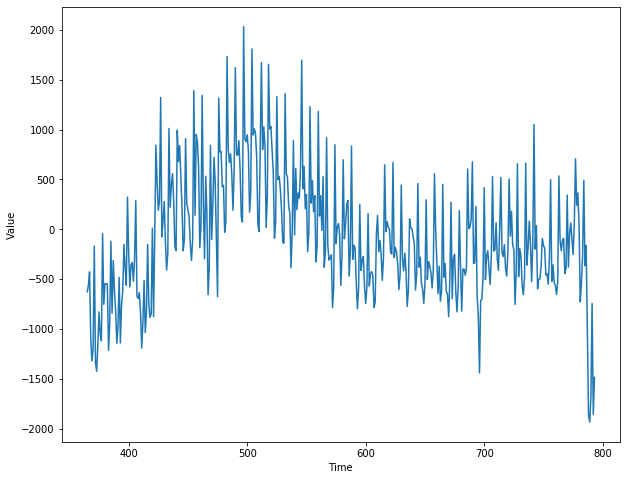

In [34]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show();

<Figure size 720x432 with 0 Axes>

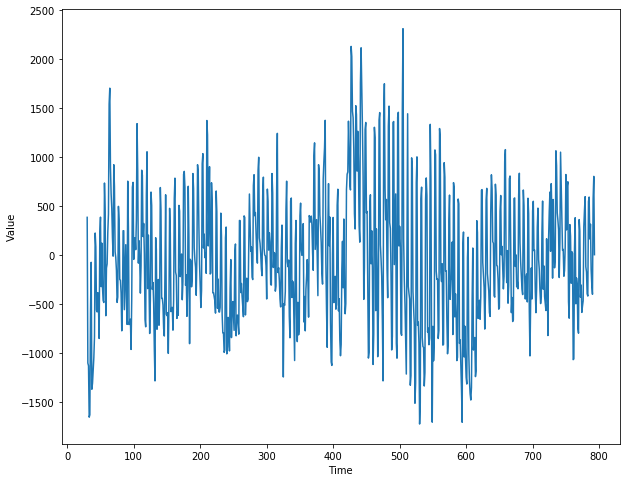

In [35]:
diff_series = (series[30:] - series[:-30])
diff_time = time[30:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show();

<Figure size 720x432 with 0 Axes>

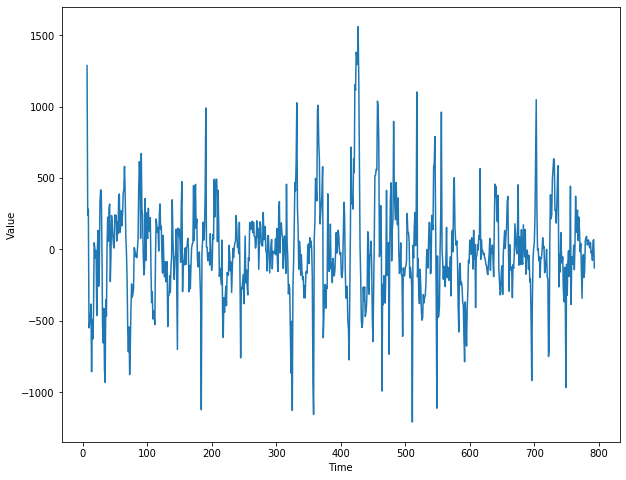

In [36]:
diff_series = (series[7:] - series[:-7])
diff_time = time[7:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show();

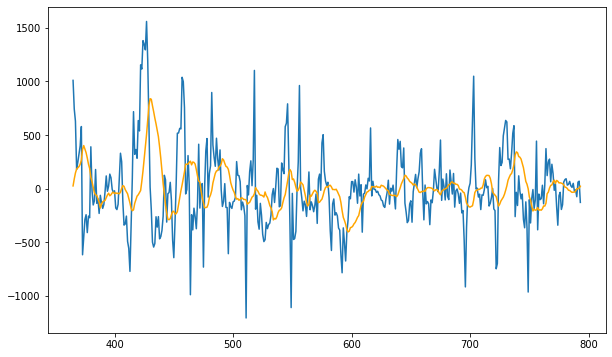

In [38]:
diff_moving_avg = moving_average_forecast(diff_series, window_size)[split_time - 7 - window_size:]

plt.figure(figsize=(10, 6))
plt.plot(time_valid, diff_series[split_time - 7:])
plt.plot(time_valid, diff_moving_avg, color='orange')
plt.show();

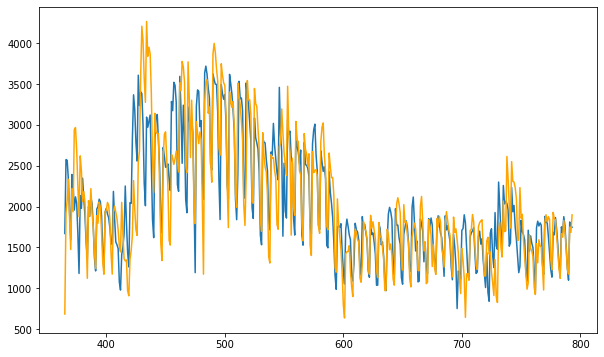

In [39]:
diff_moving_avg_plus_past = series[split_time - 7:-7] + diff_moving_avg

plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, diff_moving_avg_plus_past, color='orange')
plt.show();

In [40]:
# this is actually worse than before when using 15 days to remove seasonality
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

287.42501942501934


#### Using Pandas & statmodels

- take first degree differencing
- if the difference shows stationarity, stop there, take moving average
- use last Monday's data plus moving average on the difference to predict 

In [ ]:
sequence_data['first_order_differencing'] = sequence_data['Volume'] - sequence_data['Volume'].shift(1)

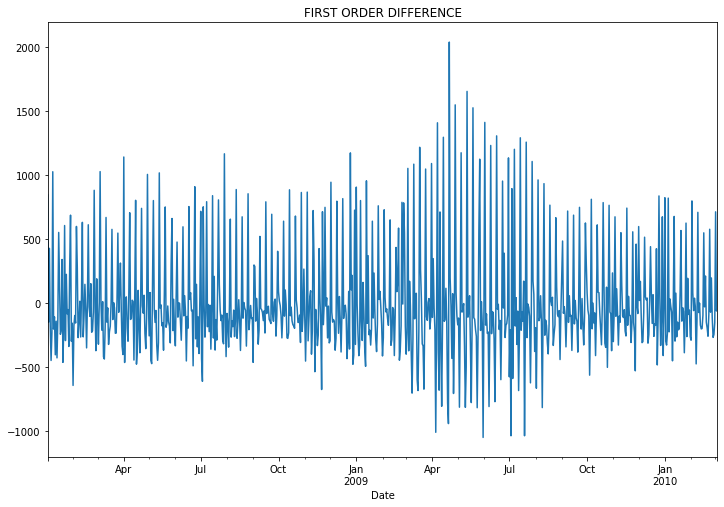

In [90]:
sequence_data['first_order_differencing'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

In [79]:
#first order differencing

sequence_data['ma_first_order_differencing'] = sequence_data['first_order_differencing'].rolling(7).mean()

sequence_data[['Volume','first_order_differencing','ma_first_order_differencing']].head(10)

,Volume,first_order_differencing,ma_first_order_differencing
Date,,,
2008-01-01,2299.0,NaN,NaN
2008-01-02,3143.0,844.0,NaN
2008-01-03,2994.0,-149.0,NaN
2008-01-04,3421.0,427.0,NaN
2008-01-05,3241.0,-180.0,NaN
2008-01-06,2793.0,-448.0,NaN
2008-01-07,2562.0,-231.0,NaN
2008-01-08,3587.0,1025.0,184.000000
2008-01-09,3384.0,-203.0,34.428571


In [84]:
sequence_data['first_order_differrencing_forecast']=sequence_data['Volume'].shift(7)+sequence_data['ma_first_order_differencing']

In [89]:
sequence_data[['Volume', 'first_order_differencing',
               'ma_first_order_differencing','first_order_differrencing_forecast']].tail(10)

,Volume,first_order_differencing,ma_first_order_differencing,first_order_differrencing_forecast
Date,,,,
2010-02-23,1752.0,576.0,9.571429,1694.571429
2010-02-24,1681.0,-71.0,3.714286,1658.714286
2010-02-25,1877.0,196.0,1.571429,1867.571429
2010-02-26,1766.0,-111.0,7.000000,1724.000000
2010-02-27,1498.0,-268.0,-3.571429,1519.428571
2010-02-28,1252.0,-246.0,-1.714286,1262.285714
2010-03-01,1100.0,-152.0,-10.857143,1165.142857
2010-03-02,1812.0,712.0,8.571429,1760.571429
2010-03-03,1750.0,-62.0,9.857143,1690.857143


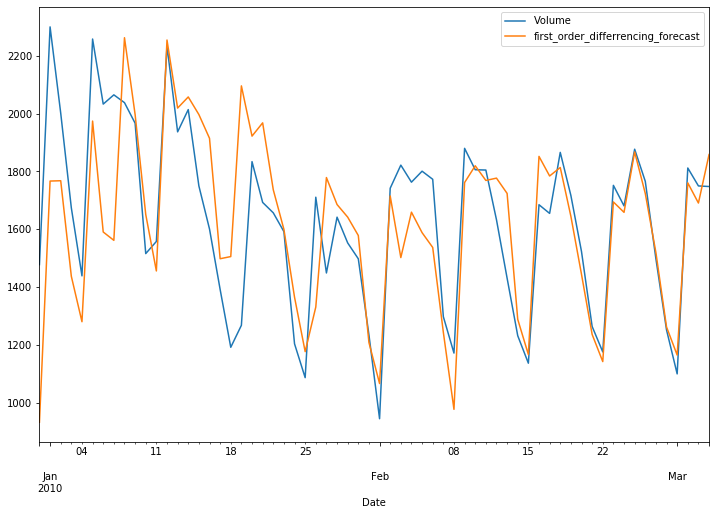

In [92]:
sequence_data.loc['2009-12-31':][['Volume','first_order_differrencing_forecast']].plot();

            Volume  weekly_differencing
Date                                   
2008-01-01  2299.0                  NaN
2008-01-02  3143.0                  NaN
2008-01-03  2994.0                  NaN
2008-01-04  3421.0                  NaN
2008-01-05  3241.0                  NaN
2008-01-06  2793.0                  NaN
2008-01-07  2562.0                  NaN
2008-01-08  3587.0               1288.0
2008-01-09  3384.0                241.0
2008-01-10  3276.0                282.0


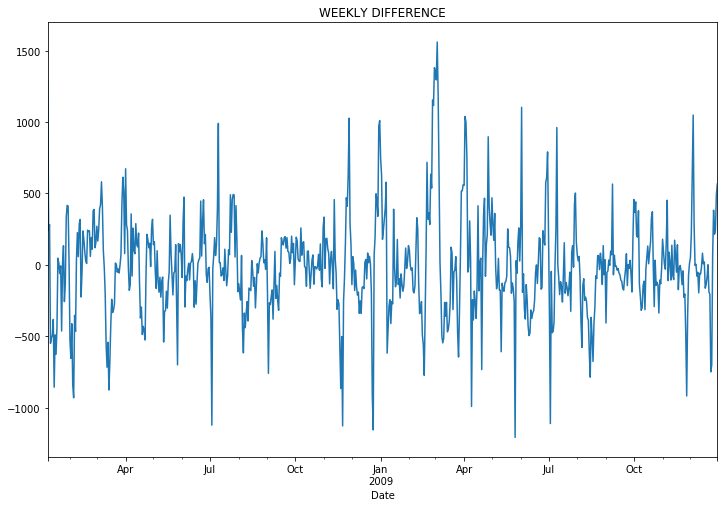

In [68]:
# An easier way to perform differencing on a pandas Series or DataFrame is to use the built-in .diff() method:

x_train_df['weekly_differencing'] = x_train_df['Volume'].diff(periods=7)
print(x_train_df[['Volume','weekly_differencing']].head(10))
x_train_df['weekly_differencing'].plot(title="WEEKLY DIFFERENCE").autoscale(axis='x',tight=True);

In [ ]:
# second degree differencing
x_train_df['Volume'].diff().diff()

In [66]:
from statsmodels.tsa.statespace.tools import diff

diff(x_train_df['Volume'], k_diff=1)

Date
2008-01-02     844.0
2008-01-03    -149.0
2008-01-04     427.0
2008-01-05    -180.0
2008-01-06    -448.0
2008-01-07    -231.0
2008-01-08    1025.0
2008-01-09    -203.0
2008-01-10    -108.0
2008-01-11    -404.0
2008-01-12    -142.0
2008-01-13    -428.0
2008-01-14    -122.0
2008-01-15     551.0
2008-01-16     163.0
2008-01-17    -244.0
2008-01-18    -213.0
2008-01-19     340.0
2008-01-20    -463.0
2008-01-21    -195.0
2008-01-22     605.0
2008-01-23    -293.0
2008-01-24     224.0
2008-01-25     -84.0
2008-01-26     -51.0
2008-01-27    -339.0
2008-01-28     274.0
2008-01-29     686.0
2008-01-30    -298.0
2008-01-31    -157.0
2008-02-01    -643.0
2008-02-02    -177.0
2008-02-03     -97.0
2008-02-04    -156.0
2008-02-05     598.0
2008-02-06     279.0
2008-02-07    -270.0
2008-02-08    -142.0
2008-02-09      14.0
2008-02-10    -265.0
2008-02-11      72.0
2008-02-12     630.0
2008-02-13    -264.0
2008-02-14     -95.0
2008-02-15     146.0
2008-02-16     -48.0
2008-02-17    -350.0
2008-02-

# ARIMA

### ACF & PACF

In [131]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols

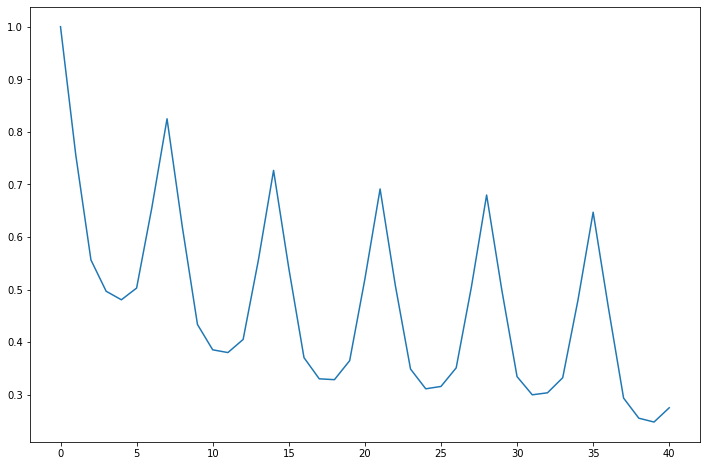

In [134]:
plt.plot(acf(sequence_data['Volume']));

In [138]:
pacf_yw(sequence_data['Volume'], nlags=7, method='mle')

array([ 1.        ,  0.7566296 , -0.03805418,  0.20751739,  0.10098521,
        0.18344274,  0.45706526,  0.50035321])

In [96]:
print('-'*125)

-----------------------------------------------------------------------------------------------------------------------------


# Neural Network Models

## Function to Produce Windowed Dataset

In [98]:
# add a random seed within the function to be able to reproduce
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
      tf.random.set_seed(345)
      dataset = tf.data.Dataset.from_tensor_slices(series)
      dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
      dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
      dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
      dataset = dataset.batch(batch_size).prefetch(1)
      return dataset

In [14]:
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# for window_dataset in dataset:
#     for val in window_dataset:
#       print(val.numpy(), end=" ")
#       print()

### Single Layer NN

In [44]:
# tf.random.set_seed(345)

In [99]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size]) #this is equivalent to regression
single_layer_model = tf.keras.models.Sequential([l0])


single_layer_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.70))
single_layer_model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.1898684 ],
       [ 0.33203095],
       [ 0.02877968],
       [-0.06527608],
       [ 0.01186454],
       [-0.02700731],
       [-0.06511752],
       [-0.35863286],
       [ 0.503774  ],
       [ 0.00666974],
       [ 0.04241803],
       [ 0.00451174],
       [ 0.0571506 ],
       [ 0.02167135],
       [ 0.6703462 ]], dtype=float32), array([0.00073104], dtype=float32)]


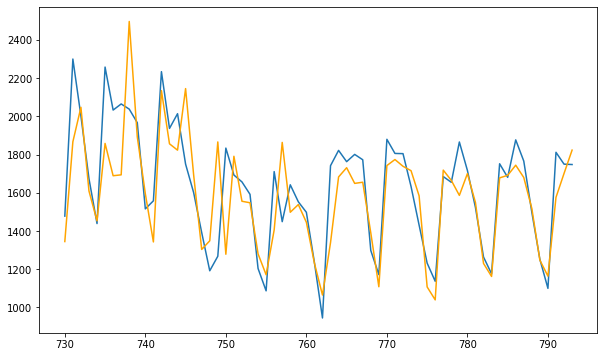

In [100]:
slm_forecast = []

for time in range(len(series) - window_size):
    slm_forecast.append(single_layer_model.predict(series[time:time + window_size][np.newaxis]))

slm_forecast = slm_forecast[split_time-window_size:]
slm_results = np.array(slm_forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plt.plot(time_valid, x_valid)
plt.plot(time_valid, slm_results, color='orange');

In [101]:
tf.keras.metrics.mean_absolute_error(x_valid, slm_results).numpy()

143.79492

### DNN

In [102]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

#change momentum improves accuracy
#adam didn't work as well
dnn_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.90), metrics=["mae"]) 
history = dnn_model.fit(dataset,epochs=50,verbose=1)

Epoch 1/50
23/23 [==============================] - 1s 27ms/step - loss: 907358.8927 - mae: 732.2596
Epoch 2/50
23/23 [==============================] - 0s 9ms/step - loss: 136549.1545 - mae: 282.8224
Epoch 3/50
23/23 [==============================] - 0s 9ms/step - loss: 89126.7564 - mae: 225.3262
Epoch 4/50
23/23 [==============================] - 0s 8ms/step - loss: 114686.1412 - mae: 269.6643
Epoch 5/50
23/23 [==============================] - 0s 9ms/step - loss: 84910.6510 - mae: 221.4467
Epoch 6/50
23/23 [==============================] - 0s 9ms/step - loss: 74499.8689 - mae: 209.2458
Epoch 7/50
23/23 [==============================] - 0s 9ms/step - loss: 113970.0309 - mae: 268.1501
Epoch 8/50
23/23 [==============================] - 0s 8ms/step - loss: 72591.6007 - mae: 200.0303
Epoch 9/50
23/23 [==============================] - 0s 8ms/step - loss: 68993.3664 - mae: 199.1578
Epoch 10/50
23/23 [==============================] - 0s 8ms/step - loss: 72851.5875 - mae: 200.9250
Epoc

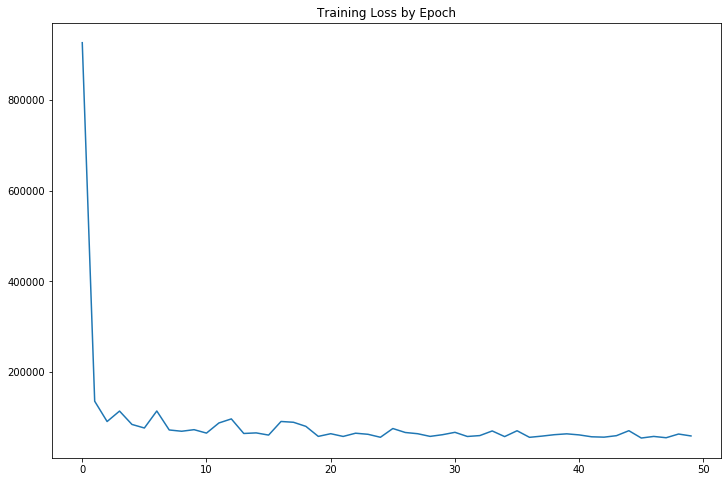

In [103]:
plt.title("Training Loss by Epoch")
plt.plot(history.history["loss"]);

<Figure size 720x432 with 0 Axes>

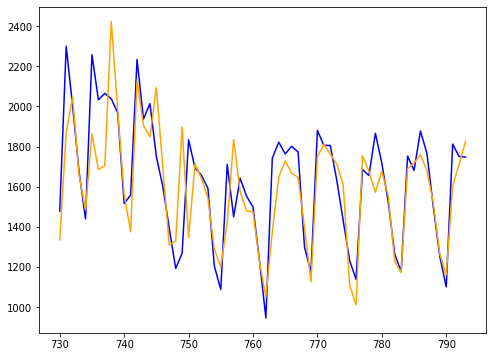

In [104]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(dnn_model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plt.figure(figsize=(8,6))
plt.plot(time_valid, x_valid, color='blue')
plt.plot(time_valid, results,color='orange');

In [109]:
valid_df=pd.DataFrame()

valid_df['time']=time_valid
valid_df['actual']=x_valid
valid_df['slm_forecast']=slm_results
valid_df['dnn_forecast']=results

In [110]:
valid_df.head(10)

,time,actual,slm_forecast,dnn_forecast
0,730.0,1478.0,1344.923096,1334.735596
1,731.0,2300.0,1867.129395,1870.618042
2,732.0,2002.0,2047.578003,2046.593994
3,733.0,1674.0,1609.461182,1656.476685
4,734.0,1439.0,1453.238525,1483.505371
5,735.0,2258.0,1858.509033,1863.263794
6,736.0,2033.0,1689.378662,1684.918457
7,737.0,2065.0,1694.007202,1704.345825
8,738.0,2038.0,2496.677979,2423.642578
9,739.0,1967.0,1892.706299,1979.877563


In [111]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

134.55396

In [113]:
# valid_df.tail(15)['actual']
# print("MAE of Moving Average Forecast:", tf.keras.metrics.mean_absolute_error(valid_df.tail(30)['actual'], valid_df.tail(30)['moving_average']).numpy())
print("MAE of DNN Forecast:", tf.keras.metrics.mean_absolute_error(valid_df.tail(30)['actual'], valid_df.tail(30)['dnn_forecast']).numpy())
print("MAE of single layer model:", tf.keras.metrics.mean_absolute_error(valid_df.tail(30)['actual'], valid_df.tail(30)['slm_forecast']).numpy())

MAE of DNN Forecast: 83.939804
MAE of single layer model: 81.778206


### Use Learning Rate Scheduler to Find the Optimal LR

In [114]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
history = model.fit(dataset, epochs=50, callbacks=[lr_schedule], verbose=0)

In [33]:
# for i in np.arange(50)/20:
#     print(1e-8*10 ** i)

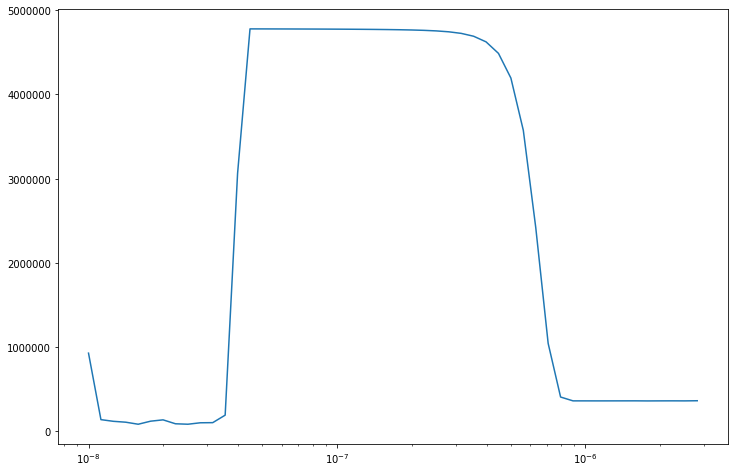

In [115]:
lrs = 1e-8 * (10 ** (np.arange(50) / 20))
plt.semilogx(lrs, history.history["loss"])
# plt.axis([1e-8, 1e-3, 0, 500])

In [35]:
import pandas as pd
history_df=pd.DataFrame()
history_df['lr']=lrs
history_df['loss']=history.history['loss']

In [36]:
history_df.head(10)

,lr,loss
0,1.000000e-08,1.254848e+06
1,1.122018e-08,3.742195e+05
2,1.258925e-08,1.908132e+05
3,1.412538e-08,1.543709e+05
4,1.584893e-08,1.049828e+05
5,1.778279e-08,9.044160e+04
6,1.995262e-08,8.495667e+04
7,2.238721e-08,8.561282e+04
8,2.511886e-08,8.689866e+04
9,2.818383e-08,9.109083e+04


In [38]:
history_df['loss'].min()
print(history_df[history_df.loss == history_df.loss.min()]) 

              lr          loss
10  3.162278e-08  80606.148661


### Train w Huber Loss

In [ ]:
# the optimal learning rate didn't work well
# Huber loss is less sensitive to outliers
# MAE much larger with Huber loss

In [118]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

#change momentum improves accuracy
#adam didn't work as well
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), metrics=["mae"]) 
history = model.fit(dataset,epochs=1000,verbose=1)

Epoch 1/1000
23/23 [==============================] - 0s 20ms/step - loss: 2320.1362 - mae: 2318.7886
Epoch 2/1000
23/23 [==============================] - 0s 8ms/step - loss: 2249.8688 - mae: 2249.8457
Epoch 3/1000
23/23 [==============================] - 0s 8ms/step - loss: 2165.3134 - mae: 2167.8091
Epoch 4/1000
23/23 [==============================] - 0s 8ms/step - loss: 2084.1743 - mae: 2082.4717
Epoch 5/1000
23/23 [==============================] - 0s 8ms/step - loss: 1998.8465 - mae: 1995.0084
Epoch 6/1000
23/23 [==============================] - 0s 7ms/step - loss: 1901.8767 - mae: 1905.2292
Epoch 7/1000
23/23 [==============================] - 0s 7ms/step - loss: 1814.2192 - mae: 1815.3843
Epoch 8/1000
23/23 [==============================] - 0s 7ms/step - loss: 1725.9182 - mae: 1726.2384
Epoch 9/1000
23/23 [==============================] - 0s 8ms/step - loss: 1638.8488 - mae: 1638.1820
Epoch 10/1000
23/23 [==============================] - 0s 8ms/step - loss: 1551.0129 - mae

23/23 [==============================] - 0s 7ms/step - loss: 385.1549 - mae: 385.3473
Epoch 83/1000
23/23 [==============================] - 0s 7ms/step - loss: 381.1425 - mae: 385.0518
Epoch 84/1000
23/23 [==============================] - 0s 7ms/step - loss: 381.6346 - mae: 384.6878
Epoch 85/1000
23/23 [==============================] - 0s 7ms/step - loss: 386.1646 - mae: 384.4236
Epoch 86/1000
23/23 [==============================] - 0s 7ms/step - loss: 384.3152 - mae: 383.9968
Epoch 87/1000
23/23 [==============================] - 0s 7ms/step - loss: 379.9404 - mae: 383.6640
Epoch 88/1000
23/23 [==============================] - 0s 7ms/step - loss: 383.4572 - mae: 383.3289
Epoch 89/1000
23/23 [==============================] - 0s 8ms/step - loss: 385.3673 - mae: 383.0546
Epoch 90/1000
23/23 [==============================] - 0s 8ms/step - loss: 382.3946 - mae: 382.6736
Epoch 91/1000
23/23 [==============================] - 0s 7ms/step - loss: 380.8847 - mae: 382.3112
Epoch 92/1000


23/23 [==============================] - 0s 8ms/step - loss: 353.1348 - mae: 352.8192
Epoch 164/1000
23/23 [==============================] - 0s 8ms/step - loss: 353.0887 - mae: 352.3598
Epoch 165/1000
23/23 [==============================] - 0s 8ms/step - loss: 350.0722 - mae: 351.9195
Epoch 166/1000
23/23 [==============================] - 0s 8ms/step - loss: 351.4157 - mae: 351.4873
Epoch 167/1000
23/23 [==============================] - 0s 7ms/step - loss: 351.7136 - mae: 351.0616
Epoch 168/1000
23/23 [==============================] - 0s 7ms/step - loss: 350.7496 - mae: 350.7018
Epoch 169/1000
23/23 [==============================] - 0s 8ms/step - loss: 349.5523 - mae: 350.2090
Epoch 170/1000
23/23 [==============================] - 0s 7ms/step - loss: 348.4020 - mae: 349.8015
Epoch 171/1000
23/23 [==============================] - 0s 8ms/step - loss: 349.1897 - mae: 349.3971
Epoch 172/1000
23/23 [==============================] - 0s 7ms/step - loss: 349.7145 - mae: 349.0317
Epoch

23/23 [==============================] - 0s 8ms/step - loss: 325.8283 - mae: 326.6805
Epoch 245/1000
23/23 [==============================] - 0s 8ms/step - loss: 326.4393 - mae: 326.4669
Epoch 246/1000
23/23 [==============================] - 0s 8ms/step - loss: 324.7189 - mae: 326.2601
Epoch 247/1000
23/23 [==============================] - 0s 8ms/step - loss: 324.2994 - mae: 326.0585
Epoch 248/1000
23/23 [==============================] - 0s 8ms/step - loss: 324.8421 - mae: 325.8319
Epoch 249/1000
23/23 [==============================] - 0s 8ms/step - loss: 324.6839 - mae: 325.5938
Epoch 250/1000
23/23 [==============================] - 0s 8ms/step - loss: 324.6629 - mae: 325.3602
Epoch 251/1000
23/23 [==============================] - 0s 9ms/step - loss: 325.5303 - mae: 325.2103
Epoch 252/1000
23/23 [==============================] - 0s 8ms/step - loss: 325.8974 - mae: 325.0344
Epoch 253/1000
23/23 [==============================] - 0s 8ms/step - loss: 322.5582 - mae: 324.7455
Epoch

23/23 [==============================] - 0s 8ms/step - loss: 311.0175 - mae: 311.2518
Epoch 325/1000
23/23 [==============================] - 0s 8ms/step - loss: 312.3863 - mae: 311.0673
Epoch 326/1000
23/23 [==============================] - 0s 8ms/step - loss: 310.1096 - mae: 310.9279
Epoch 327/1000
23/23 [==============================] - 0s 8ms/step - loss: 312.2989 - mae: 310.7393
Epoch 328/1000
23/23 [==============================] - 0s 8ms/step - loss: 310.3571 - mae: 310.5937
Epoch 329/1000
23/23 [==============================] - 0s 8ms/step - loss: 310.1287 - mae: 310.3817
Epoch 330/1000
23/23 [==============================] - 0s 8ms/step - loss: 308.6775 - mae: 310.1996
Epoch 331/1000
23/23 [==============================] - 0s 8ms/step - loss: 307.4798 - mae: 310.0228
Epoch 332/1000
23/23 [==============================] - 0s 9ms/step - loss: 307.6650 - mae: 309.8651
Epoch 333/1000
23/23 [==============================] - 0s 8ms/step - loss: 309.6318 - mae: 309.6778
Epoch

23/23 [==============================] - 0s 7ms/step - loss: 298.8867 - mae: 298.6608
Epoch 405/1000
23/23 [==============================] - 0s 8ms/step - loss: 298.2201 - mae: 298.5121
Epoch 406/1000
23/23 [==============================] - 0s 8ms/step - loss: 299.3018 - mae: 298.4080
Epoch 407/1000
23/23 [==============================] - 0s 8ms/step - loss: 297.4829 - mae: 298.2248
Epoch 408/1000
23/23 [==============================] - 0s 7ms/step - loss: 298.5173 - mae: 298.2097
Epoch 409/1000
23/23 [==============================] - 0s 7ms/step - loss: 297.1292 - mae: 298.0470
Epoch 410/1000
23/23 [==============================] - 0s 7ms/step - loss: 296.6541 - mae: 297.8076
Epoch 411/1000
23/23 [==============================] - 0s 7ms/step - loss: 295.7787 - mae: 297.7123
Epoch 412/1000
23/23 [==============================] - 0s 7ms/step - loss: 298.6754 - mae: 297.6168
Epoch 413/1000
23/23 [==============================] - 0s 8ms/step - loss: 300.1560 - mae: 297.4373
Epoch

23/23 [==============================] - 0s 7ms/step - loss: 288.7433 - mae: 287.5224
Epoch 486/1000
23/23 [==============================] - 0s 8ms/step - loss: 286.6594 - mae: 287.3734
Epoch 487/1000
23/23 [==============================] - 0s 8ms/step - loss: 287.0636 - mae: 287.2512
Epoch 488/1000
23/23 [==============================] - 0s 8ms/step - loss: 287.2534 - mae: 287.1125
Epoch 489/1000
23/23 [==============================] - 0s 8ms/step - loss: 287.2909 - mae: 286.9973
Epoch 490/1000
23/23 [==============================] - 0s 7ms/step - loss: 286.6905 - mae: 286.8509
Epoch 491/1000
23/23 [==============================] - 0s 7ms/step - loss: 287.0015 - mae: 286.7349
Epoch 492/1000
23/23 [==============================] - 0s 7ms/step - loss: 286.8302 - mae: 286.5684
Epoch 493/1000
23/23 [==============================] - 0s 7ms/step - loss: 285.7927 - mae: 286.4380
Epoch 494/1000
23/23 [==============================] - 0s 7ms/step - loss: 286.9339 - mae: 286.3152
Epoch

23/23 [==============================] - 0s 7ms/step - loss: 275.3706 - mae: 277.0208
Epoch 567/1000
23/23 [==============================] - 0s 8ms/step - loss: 276.1453 - mae: 276.9042
Epoch 568/1000
23/23 [==============================] - 0s 7ms/step - loss: 276.9465 - mae: 276.8185
Epoch 569/1000
23/23 [==============================] - 0s 8ms/step - loss: 277.0135 - mae: 276.6641
Epoch 570/1000
23/23 [==============================] - 0s 7ms/step - loss: 275.0701 - mae: 276.5844
Epoch 571/1000
23/23 [==============================] - 0s 7ms/step - loss: 277.6592 - mae: 276.4363
Epoch 572/1000
23/23 [==============================] - 0s 8ms/step - loss: 276.3163 - mae: 276.2952
Epoch 573/1000
23/23 [==============================] - 0s 7ms/step - loss: 275.8722 - mae: 276.1673
Epoch 574/1000
23/23 [==============================] - 0s 8ms/step - loss: 275.1865 - mae: 276.0142
Epoch 575/1000
23/23 [==============================] - 0s 8ms/step - loss: 276.3125 - mae: 275.9155
Epoch

23/23 [==============================] - 0s 7ms/step - loss: 266.6747 - mae: 267.4218
Epoch 648/1000
23/23 [==============================] - 0s 8ms/step - loss: 266.6348 - mae: 267.3434
Epoch 649/1000
23/23 [==============================] - 0s 8ms/step - loss: 267.6300 - mae: 267.2292
Epoch 650/1000
23/23 [==============================] - 0s 8ms/step - loss: 267.7498 - mae: 267.0922
Epoch 651/1000
23/23 [==============================] - 0s 8ms/step - loss: 267.9417 - mae: 266.9867
Epoch 652/1000
23/23 [==============================] - 0s 7ms/step - loss: 264.5233 - mae: 266.9087
Epoch 653/1000
23/23 [==============================] - 0s 7ms/step - loss: 266.9025 - mae: 266.8437
Epoch 654/1000
23/23 [==============================] - 0s 7ms/step - loss: 267.3549 - mae: 266.6804
Epoch 655/1000
23/23 [==============================] - 0s 8ms/step - loss: 264.0398 - mae: 266.5287
Epoch 656/1000
23/23 [==============================] - 0s 7ms/step - loss: 266.6442 - mae: 266.4187
Epoch

23/23 [==============================] - 0s 8ms/step - loss: 256.3200 - mae: 258.8031
Epoch 729/1000
23/23 [==============================] - 0s 8ms/step - loss: 259.1665 - mae: 258.6500
Epoch 730/1000
23/23 [==============================] - 0s 8ms/step - loss: 259.1199 - mae: 258.6275
Epoch 731/1000
23/23 [==============================] - 0s 7ms/step - loss: 258.6733 - mae: 258.4760
Epoch 732/1000
23/23 [==============================] - 0s 8ms/step - loss: 257.5015 - mae: 258.3851
Epoch 733/1000
23/23 [==============================] - 0s 8ms/step - loss: 255.3192 - mae: 258.3045
Epoch 734/1000
23/23 [==============================] - 0s 8ms/step - loss: 257.6826 - mae: 258.2788
Epoch 735/1000
23/23 [==============================] - 0s 8ms/step - loss: 257.9721 - mae: 258.0004
Epoch 736/1000
23/23 [==============================] - 0s 7ms/step - loss: 257.7505 - mae: 257.9184
Epoch 737/1000
23/23 [==============================] - 0s 7ms/step - loss: 256.9924 - mae: 257.8247
Epoch

23/23 [==============================] - 0s 7ms/step - loss: 252.2058 - mae: 250.6557
Epoch 810/1000
23/23 [==============================] - 0s 7ms/step - loss: 248.0997 - mae: 250.6501
Epoch 811/1000
23/23 [==============================] - 0s 7ms/step - loss: 250.2509 - mae: 250.5004
Epoch 812/1000
23/23 [==============================] - 0s 8ms/step - loss: 249.1748 - mae: 250.3723
Epoch 813/1000
23/23 [==============================] - 0s 7ms/step - loss: 250.4535 - mae: 250.2823
Epoch 814/1000
23/23 [==============================] - 0s 8ms/step - loss: 249.3437 - mae: 250.2858
Epoch 815/1000
23/23 [==============================] - 0s 8ms/step - loss: 249.4066 - mae: 250.1307
Epoch 816/1000
23/23 [==============================] - 0s 8ms/step - loss: 248.7449 - mae: 250.0321
Epoch 817/1000
23/23 [==============================] - 0s 8ms/step - loss: 249.5410 - mae: 249.9041
Epoch 818/1000
23/23 [==============================] - 0s 8ms/step - loss: 250.0596 - mae: 249.8286
Epoch

23/23 [==============================] - 0s 8ms/step - loss: 242.7446 - mae: 243.3586
Epoch 891/1000
23/23 [==============================] - 0s 8ms/step - loss: 242.8522 - mae: 243.2687
Epoch 892/1000
23/23 [==============================] - 0s 8ms/step - loss: 243.7983 - mae: 243.1960
Epoch 893/1000
23/23 [==============================] - 0s 7ms/step - loss: 240.6622 - mae: 243.0626
Epoch 894/1000
23/23 [==============================] - 0s 8ms/step - loss: 242.0731 - mae: 242.9779
Epoch 895/1000
23/23 [==============================] - 0s 8ms/step - loss: 241.9730 - mae: 242.9072
Epoch 896/1000
23/23 [==============================] - 0s 8ms/step - loss: 241.6057 - mae: 243.0297
Epoch 897/1000
23/23 [==============================] - 0s 7ms/step - loss: 242.6221 - mae: 242.7338
Epoch 898/1000
23/23 [==============================] - 0s 9ms/step - loss: 241.9966 - mae: 242.6348
Epoch 899/1000
23/23 [==============================] - 0s 8ms/step - loss: 241.6569 - mae: 242.5545
Epoch

23/23 [==============================] - 0s 8ms/step - loss: 236.3494 - mae: 236.6850
Epoch 972/1000
23/23 [==============================] - 0s 8ms/step - loss: 235.9844 - mae: 236.6604
Epoch 973/1000
23/23 [==============================] - 0s 7ms/step - loss: 236.6916 - mae: 236.5484
Epoch 974/1000
23/23 [==============================] - 0s 8ms/step - loss: 237.1080 - mae: 236.4212
Epoch 975/1000
23/23 [==============================] - 0s 7ms/step - loss: 236.0612 - mae: 236.3757
Epoch 976/1000
23/23 [==============================] - 0s 8ms/step - loss: 235.1284 - mae: 236.4104
Epoch 977/1000
23/23 [==============================] - 0s 8ms/step - loss: 236.7555 - mae: 236.1997
Epoch 978/1000
23/23 [==============================] - 0s 8ms/step - loss: 235.8679 - mae: 236.1890
Epoch 979/1000
23/23 [==============================] - 0s 8ms/step - loss: 235.4202 - mae: 236.0405
Epoch 980/1000
23/23 [==============================] - 0s 8ms/step - loss: 235.7635 - mae: 235.9655
Epoch

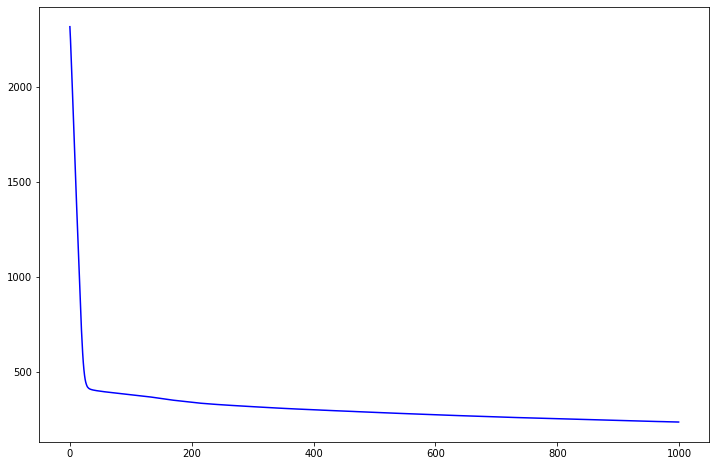

In [119]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

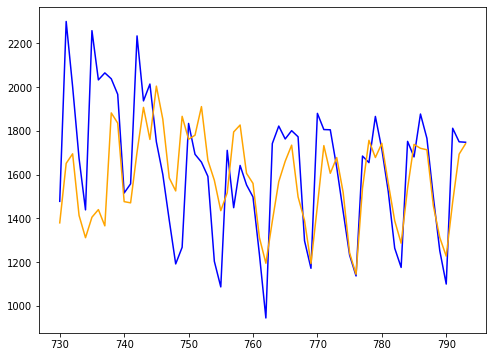

In [121]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(8,6))
plt.plot(time_valid, x_valid, color='blue')
plt.plot(time_valid, results,color='orange');

In [122]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

197.99557

### Simple RNN

In [123]:
window_size = 15
batch_size = 32
shuffle_buffer_size = 1000

In [130]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(
#               loss=tf.keras.losses.Huber(),
              loss="mse", 
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=40, callbacks=[lr_schedule])

Epoch 1/40
23/23 [==============================] - 1s 62ms/step - loss: 2045020.6997 - mae: 1252.1023
Epoch 2/40
23/23 [==============================] - 0s 14ms/step - loss: 380030.9980 - mae: 488.0378
Epoch 3/40
23/23 [==============================] - 0s 14ms/step - loss: 369581.2643 - mae: 495.7803
Epoch 4/40
23/23 [==============================] - 0s 14ms/step - loss: 360778.0814 - mae: 480.7380
Epoch 5/40
23/23 [==============================] - 0s 14ms/step - loss: 360262.4610 - mae: 483.2677
Epoch 6/40
23/23 [==============================] - 0s 13ms/step - loss: 358755.1755 - mae: 480.7652
Epoch 7/40
23/23 [==============================] - 0s 13ms/step - loss: 358740.9482 - mae: 484.3850
Epoch 8/40
23/23 [==============================] - 0s 14ms/step - loss: 362817.8145 - mae: 480.3419
Epoch 9/40
23/23 [==============================] - 0s 14ms/step - loss: 360133.1951 - mae: 484.0152
Epoch 10/40
23/23 [==============================] - 0s 14ms/step - loss: 356835.9430 - m

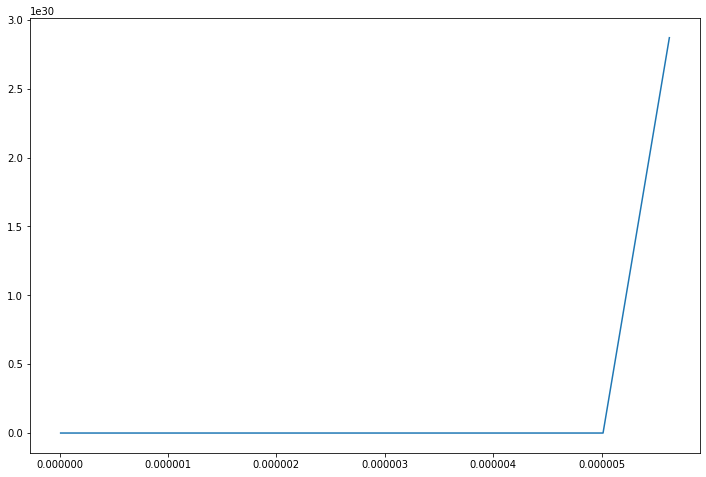

In [125]:
plt.plot(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 30])

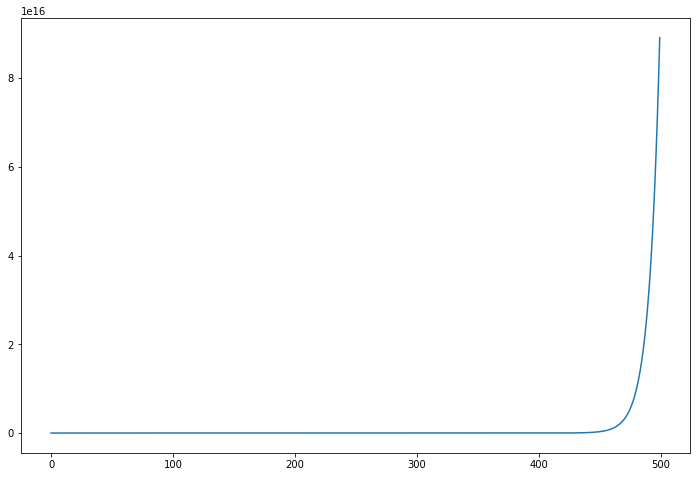

In [126]:
plt.plot(history.history['lr'])

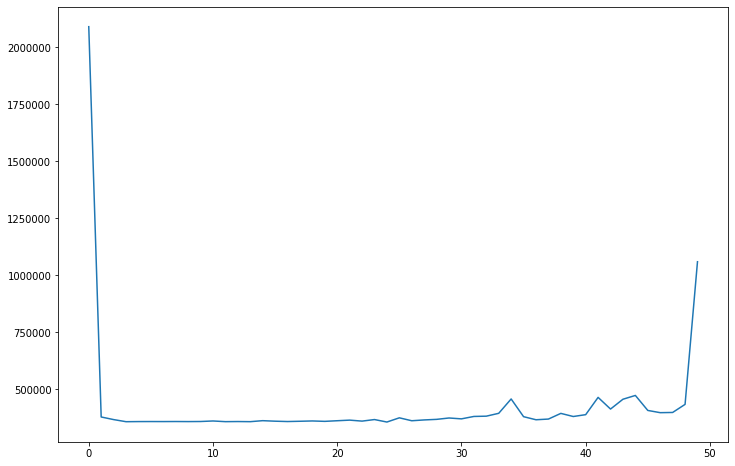

In [129]:
plt.plot(history.history["loss"])

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# dataset = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# optimizer = tf.keras.optimizers.Adam(lr=1e-8)

model.compile(
#               loss=tf.keras.losses.Huber(),
              loss="mse",
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset,epochs=100, verbose=1)

Epoch 1/100
11/11 [==============================] - 1s 108ms/step - loss: 3984316.5909 - mae: 1945.7843
Epoch 2/100
11/11 [==============================] - 0s 15ms/step - loss: 2843593.2577 - mae: 1611.3413
Epoch 3/100
11/11 [==============================] - 0s 15ms/step - loss: 1954470.2149 - mae: 1320.6497
Epoch 4/100
11/11 [==============================] - 0s 15ms/step - loss: 1276302.6970 - mae: 1034.5354
Epoch 5/100
11/11 [==============================] - 0s 15ms/step - loss: 821340.2776 - mae: 791.6179
Epoch 6/100
11/11 [==============================] - 0s 15ms/step - loss: 517013.9310 - mae: 612.7653
Epoch 7/100
11/11 [==============================] - 0s 15ms/step - loss: 376889.5824 - mae: 494.7413
Epoch 8/100
11/11 [==============================] - 0s 15ms/step - loss: 280390.9921 - mae: 425.0238
Epoch 9/100
11/11 [==============================] - 0s 16ms/step - loss: 241450.6511 - mae: 387.9156
Epoch 10/100
11/11 [==============================] - 0s 15ms/step - loss

11/11 [==============================] - 0s 16ms/step - loss: 192999.4564 - mae: 352.1124
Epoch 81/100
11/11 [==============================] - 0s 16ms/step - loss: 197378.6572 - mae: 352.1055
Epoch 82/100
11/11 [==============================] - ETA: 0s - loss: 209179.2165 - mae: 366.20 - 0s 16ms/step - loss: 197942.7965 - mae: 352.1195
Epoch 83/100
11/11 [==============================] - 0s 15ms/step - loss: 192902.3302 - mae: 352.1158
Epoch 84/100
11/11 [==============================] - 0s 16ms/step - loss: 195352.3145 - mae: 352.1344
Epoch 85/100
11/11 [==============================] - 0s 16ms/step - loss: 195834.8036 - mae: 352.2032
Epoch 86/100
11/11 [==============================] - 0s 16ms/step - loss: 192467.6387 - mae: 352.1188
Epoch 87/100
11/11 [==============================] - 0s 15ms/step - loss: 189641.1615 - mae: 352.1118
Epoch 88/100
11/11 [==============================] - 0s 15ms/step - loss: 195646.8332 - mae: 352.1092
Epoch 89/100
11/11 [======================

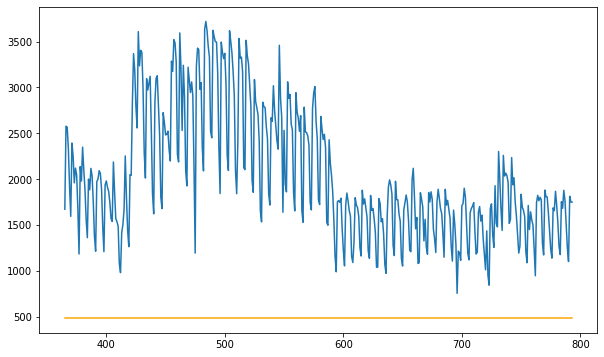

In [21]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plt.plot(time_valid, x_valid)
plt.plot(time_valid, results, color='orange');

### LSTM

In [32]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size=7

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(
#               loss=tf.keras.losses.Huber(),
              loss="mse",
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset, epochs=40, callbacks=[lr_schedule])

Epoch 1/40
12/12 [==============================] - 7s 589ms/step - loss: 4419259.4167 - mae: 2053.7058
Epoch 2/40
12/12 [==============================] - 0s 26ms/step - loss: 3347314.8387 - mae: 1761.5583
Epoch 3/40
12/12 [==============================] - 0s 26ms/step - loss: 1878050.7197 - mae: 1284.3905
Epoch 4/40
12/12 [==============================] - 0s 25ms/step - loss: 593047.9222 - mae: 644.5623
Epoch 5/40
12/12 [==============================] - 0s 26ms/step - loss: 224997.4350 - mae: 372.7026
Epoch 6/40
12/12 [==============================] - 0s 25ms/step - loss: 242520.4674 - mae: 390.6926 0s - loss: 238400.3234 - mae: 390.46
Epoch 7/40
12/12 [==============================] - 0s 26ms/step - loss: 212562.5073 - mae: 363.0599
Epoch 8/40
12/12 [==============================] - 0s 26ms/step - loss: 210521.4463 - mae: 361.8868
Epoch 9/40
12/12 [==============================] - 0s 26ms/step - loss: 210737.7975 - mae: 361.7460
Epoch 10/40
12/12 [============================

[1e-08, 0.0001, 0, 30]

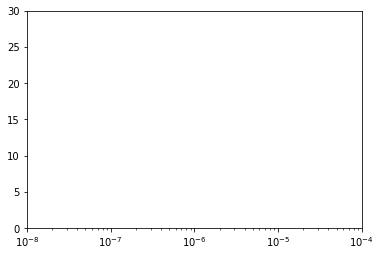

In [33]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [41]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size=15

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
   tf.keras.layers.Dense(1),
   tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=50,verbose=1)

Epoch 1/50
11/11 [==============================] - 9s 812ms/step - loss: 3898275.0000 - mae: 1920.9321
Epoch 2/50
11/11 [==============================] - 0s 34ms/step - loss: 2002035.6387 - mae: 1297.0273
Epoch 3/50
11/11 [==============================] - 0s 32ms/step - loss: 519465.4014 - mae: 596.9193
Epoch 4/50
11/11 [==============================] - 0s 38ms/step - loss: 220559.7390 - mae: 368.4894
Epoch 5/50
11/11 [==============================] - 0s 40ms/step - loss: 246205.2575 - mae: 393.7602
Epoch 6/50
11/11 [==============================] - 0s 32ms/step - loss: 196244.7272 - mae: 354.7158
Epoch 7/50
11/11 [==============================] - 0s 32ms/step - loss: 197217.7292 - mae: 353.5700
Epoch 8/50
11/11 [==============================] - 0s 38ms/step - loss: 192384.1992 - mae: 352.8507
Epoch 9/50
11/11 [==============================] - 0s 40ms/step - loss: 197736.5890 - mae: 352.0615
Epoch 10/50
11/11 [==============================] - 0s 36ms/step - loss: 203326.7078 

<Figure size 720x432 with 0 Axes>

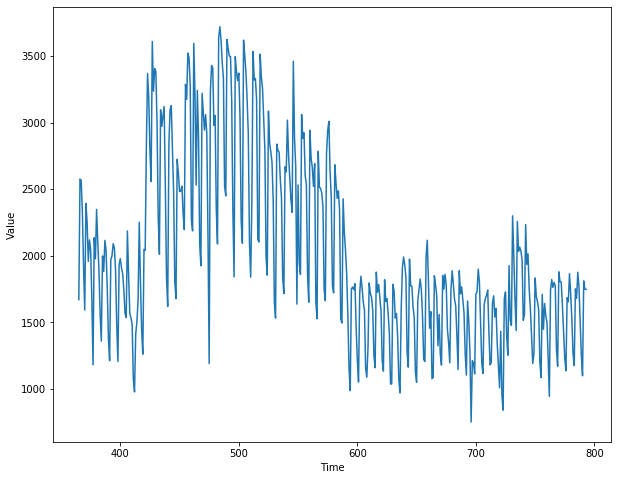

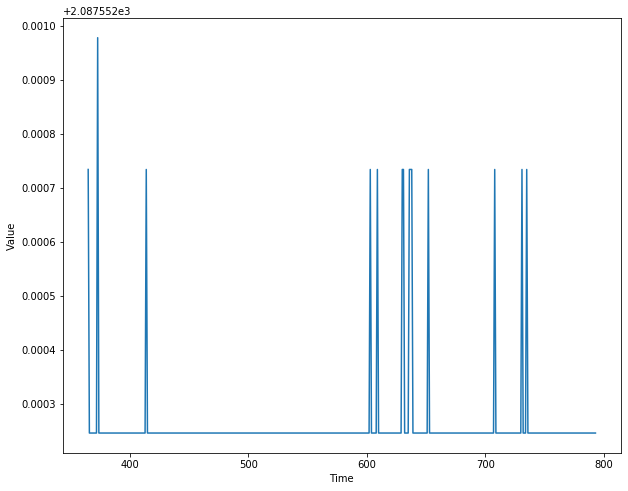

In [39]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

### LSTM with CNN

NEW window function

In [ ]:
# NEW window function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

#### Combine CNN, LSTM and DNN

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()